In [ ]:
import numpy as np

def read_pgm(path):
    with open(path, 'rb') as f:
        magic = f.readline().strip()
        if magic != b'P5':
            raise ValueError("Not a P5 PGM file")

        width = int(f.readline().strip())
        height = int(f.readline().strip())
        max_gray = int(f.readline().strip())

        if max_gray > 255:
            raise ValueError("Only 8-bit PGM supported")

        image_data = f.read(width * height)

        if len(image_data) != width * height:
            raise ValueError("Incomplete image data")

        image = np.frombuffer(image_data, dtype=np.uint8)
        image = image.reshape((height, width))

        return image


In [ ]:
def read_eye_positions(path):
    """Read eye positions from .eye file"""
    with open(path, 'r') as f:
        f.readline()
        coords = f.readline().strip().split()
        left_x, left_y, right_x, right_y = map(int, coords)
        return (left_x, left_y), (right_x, right_y)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def visualize_image_with_eyes(image_path, eye_path, box_width=50, box_height=30):
    """
    Load image and visualize with bounding boxes around eyes
    
    Args:
        image_path: Path to .pgm image file
        eye_path: Path to .eye annotation file
        box_width: Width of the bounding box centered on eye
        box_height: Height of the bounding box centered on eye
    """
    
    image = read_pgm(image_path)

    left_eye, right_eye = read_eye_positions(eye_path)
    
    _, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image, cmap='gray')
    
    for eye_pos, label in [(left_eye, 'Left Eye'), (right_eye, 'Right Eye')]:
        x, y = eye_pos
        
        box_x = x - box_width // 2
        box_y = y - box_height // 2
        
        rect = patches.Rectangle(
            (box_x, box_y), box_width, box_height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
    
        ax.add_patch(rect)

        ax.plot(x, y, 'g+', markersize=10, markeredgewidth=2)

        ax.text(x, box_y - 5, label, color='yellow', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    ax.set_title(os.path.basename(image_path))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

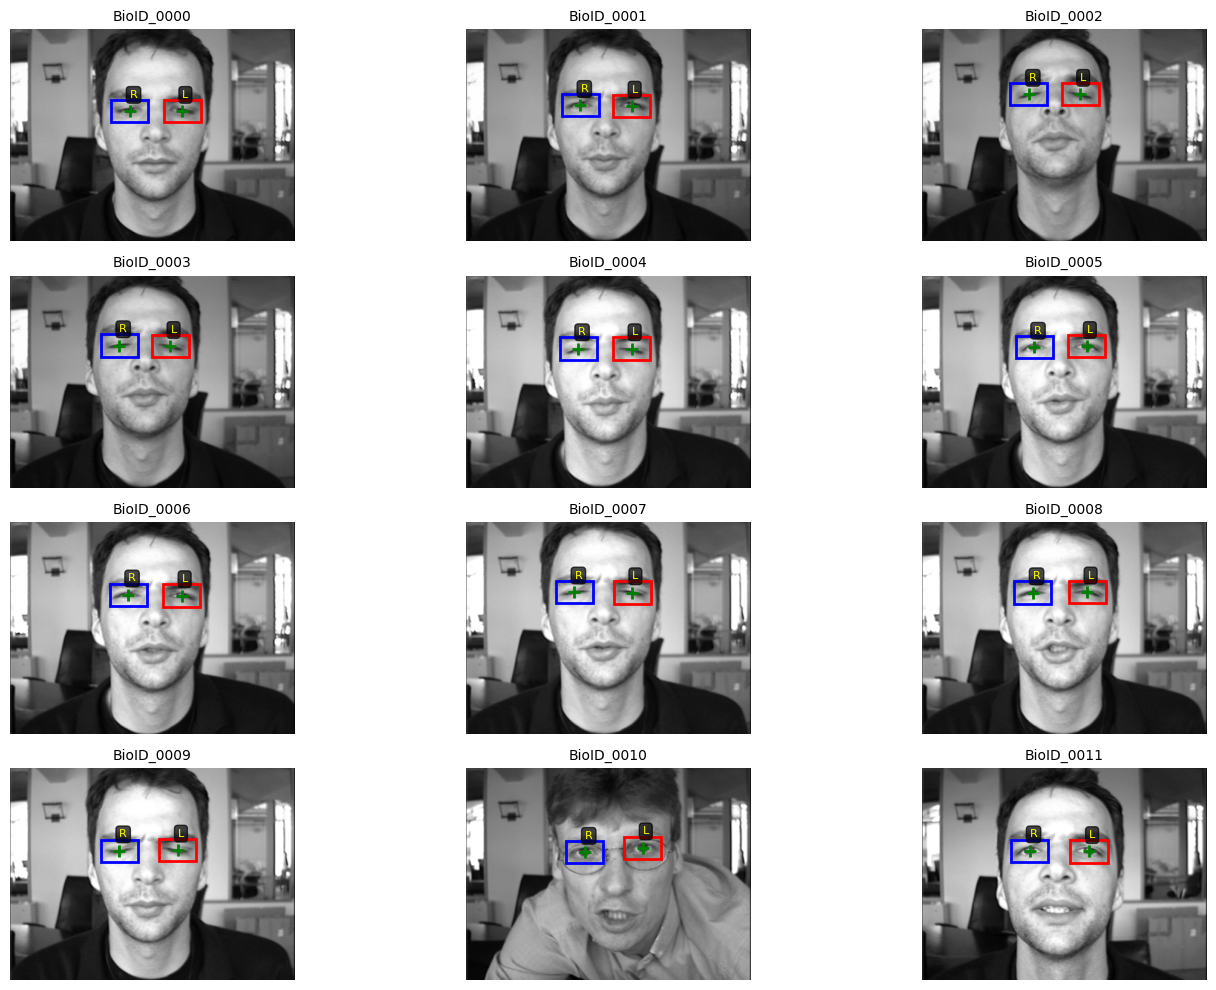

In [ ]:
dataset_dir = 'dataset'

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(12):
    image_name = f'BioID_{i:04d}'
    image_path = os.path.join(dataset_dir, f'{image_name}.pgm')
    eye_path = os.path.join(dataset_dir, f'{image_name}.eye')
    
    image = read_pgm(image_path)
    left_eye, right_eye = read_eye_positions(eye_path)
    
    axes[i].imshow(image, cmap='gray')
    
    box_width = 50   
    box_height = 30  
    for eye_pos, color, label in [(left_eye, 'red', 'L'), (right_eye, 'blue', 'R')]:
        x, y = eye_pos
        box_x = x - box_width // 2
        box_y = y - box_height // 2
        
        rect = patches.Rectangle(
            (box_x, box_y), box_width, box_height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        axes[i].add_patch(rect)
        
        axes[i].plot(x, y, 'g+', markersize=8, markeredgewidth=2)
        
        axes[i].text(x, box_y - 3, label, color='yellow', fontsize=8, 
                    bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    axes[i].set_title(image_name, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create Eye Detection Dataset

Now we'll prepare the dataset for training an object detector. We'll:
1. Process all images and extract eye bounding boxes
2. Create annotations in YOLO format (normalized coordinates)
3. Split into train/validation sets
4. Save the dataset structure

In [ ]:
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

BOX_WIDTH = 50
BOX_HEIGHT = 30

def get_all_images(dataset_dir):
    """Get all .pgm image files from dataset"""
    pgm_files = sorted(glob.glob(os.path.join(dataset_dir, '*.pgm')))
    return pgm_files

def create_eye_bbox(center_x, center_y, box_width, box_height, img_width, img_height):
    """
    Create bounding box from center point
    Returns: (x_min, y_min, x_max, y_max) in pixel coordinates
    """
    x_min = max(0, center_x - box_width // 2)
    y_min = max(0, center_y - box_height // 2)
    x_max = min(img_width, center_x + box_width // 2)
    y_max = min(img_height, center_y + box_height // 2)
    return x_min, y_min, x_max, y_max

def bbox_to_yolo(x_min, y_min, x_max, y_max, img_width, img_height):
    """
    Convert bounding box to YOLO format (normalized center coordinates)
    YOLO format: class_id x_center y_center width height (all normalized 0-1)
    """
    x_center = ((x_min + x_max) / 2) / img_width
    y_center = ((y_min + y_max) / 2) / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return x_center, y_center, width, height


print("Processing images...")
all_data = []

image_files = get_all_images(dataset_dir)
print(f"Found {len(image_files)} images")

for img_path in image_files:
    eye_path = img_path.replace('.pgm', '.eye')

    if not os.path.exists(eye_path):
        continue
    
    image = read_pgm(img_path)
    img_height, img_width = image.shape
    
    left_eye, right_eye = read_eye_positions(eye_path)
    
    for eye_pos, eye_label in [(left_eye, 'left'), (right_eye, 'right')]:
        x, y = eye_pos
        x_min, y_min, x_max, y_max = create_eye_bbox(
            x, y, BOX_WIDTH, BOX_HEIGHT, img_width, img_height
        )
        
        x_center, y_center, width, height = bbox_to_yolo(
            x_min, y_min, x_max, y_max, img_width, img_height
        )
        
        all_data.append({
            'image_path': img_path,
            'image_name': os.path.basename(img_path),
            'eye_type': eye_label,
            'center_x': x,
            'center_y': y,
            'bbox_x_min': x_min,
            'bbox_y_min': y_min,
            'bbox_x_max': x_max,
            'bbox_y_max': y_max,
            'yolo_x_center': x_center,
            'yolo_y_center': y_center,
            'yolo_width': width,
            'yolo_height': height,
            'img_width': img_width,
            'img_height': img_height
        })


df = pd.DataFrame(all_data)
print(f"\nCreated dataset with {len(df)} eye annotations from {len(image_files)} images")
print(f"Each image has 2 eyes (left and right)")
df.head()

Processing images...
Found 1521 images

Created dataset with 3042 eye annotations from 1521 images
Each image has 2 eyes (left and right)


,image_path,image_name,eye_type,center_x,center_y,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max,yolo_x_center,yolo_y_center,yolo_width,yolo_height,img_width,img_height
0,dataset\BioID_0000.pgm,BioID_0000.pgm,left,232,110,207,95,257,125,0.604167,0.384615,0.130208,0.104895,384,286
1,dataset\BioID_0000.pgm,BioID_0000.pgm,right,161,110,136,95,186,125,0.419271,0.384615,0.130208,0.104895,384,286
2,dataset\BioID_0001.pgm,BioID_0001.pgm,left,223,103,198,88,248,118,0.580729,0.360140,0.130208,0.104895,384,286
3,dataset\BioID_0001.pgm,BioID_0001.pgm,right,154,102,129,87,179,117,0.401042,0.356643,0.130208,0.104895,384,286
4,dataset\BioID_0002.pgm,BioID_0002.pgm,left,213,87,188,72,238,102,0.554688,0.304196,0.130208,0.104895,384,286


In [ ]:
unique_images = df['image_name'].unique()
print(f"Total unique images: {len(unique_images)}")

train_images, val_images = train_test_split(
    unique_images, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

train_df = df[df['image_name'].isin(train_images)].copy()
val_df = df[df['image_name'].isin(val_images)].copy()

print(f"\nTraining annotations: {len(train_df)}")
print(f"Validation annotations: {len(val_df)}")

Total unique images: 1521
Training images: 1216
Validation images: 305

Training annotations: 2432
Validation annotations: 610


In [ ]:
output_dir = 'eye_detection_dataset'
os.makedirs(output_dir, exist_ok=True)

for split in ['train', 'val']:
    os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

print("Created directory structure:")
print(f"{output_dir}/")
print("  ├── train/")
print("  │   ├── images/")
print("  │   └── labels/")
print("  └── val/")
print("      ├── images/")
print("      └── labels/")

def save_yolo_annotations(df_split, split_name):
    """Save annotations in YOLO format"""
    for image_name in df_split['image_name'].unique():
        
        img_annotations = df_split[df_split['image_name'] == image_name]
        
        
        src_img = img_annotations.iloc[0]['image_path']
        dst_img = os.path.join(output_dir, split_name, 'images', image_name)
        shutil.copy2(src_img, dst_img)
        
        
        label_file = os.path.join(
            output_dir, split_name, 'labels', 
            image_name.replace('.pgm', '.txt')
        )
        
        with open(label_file, 'w') as f:
            for _, row in img_annotations.iterrows():
                
                f.write(f"0 {row['yolo_x_center']:.6f} {row['yolo_y_center']:.6f} "
                       f"{row['yolo_width']:.6f} {row['yolo_height']:.6f}\n")

print("\nSaving training set...")
save_yolo_annotations(train_df, 'train')
print(f"Saved {len(train_images)} training images")

print("\nSaving validation set...")
save_yolo_annotations(val_df, 'val')
print(f"Saved {len(val_images)} validation images")

print("\n✓ Dataset created successfully!")

Created directory structure:
eye_detection_dataset/
  ├── train/
  │   ├── images/
  │   └── labels/
  └── val/
      ├── images/
      └── labels/

Saving training set...
Saved 1216 training images

Saving validation set...
Saved 305 validation images

✓ Dataset created successfully!


In [ ]:
yaml_content = f"""
path: {os.path.abspath(output_dir)}
train: train/images
val: val/images
nc: 1
names: ['eye']
dataset_info:
  total_images: {len(unique_images)}
  train_images: {len(train_images)}
  val_images: {len(val_images)}
  annotations_per_image: 2
  bbox_width: {BOX_WIDTH}
  bbox_height: {BOX_HEIGHT}
  source: BioID Face Database
"""

yaml_path = os.path.join(output_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Created configuration file: {yaml_path}")
print("\nYou can use this dataset with YOLO models (YOLOv5, YOLOv8, etc.)")
print(f"\nTo train with YOLOv8:")
print(f"  yolo train data={yaml_path} model=yolov8n.pt epochs=100 imgsz=384")

Created configuration file: eye_detection_dataset\data.yaml

You can use this dataset with YOLO models (YOLOv5, YOLOv8, etc.)

To train with YOLOv8:
  yolo train data=eye_detection_dataset\data.yaml model=yolov8n.pt epochs=100 imgsz=384


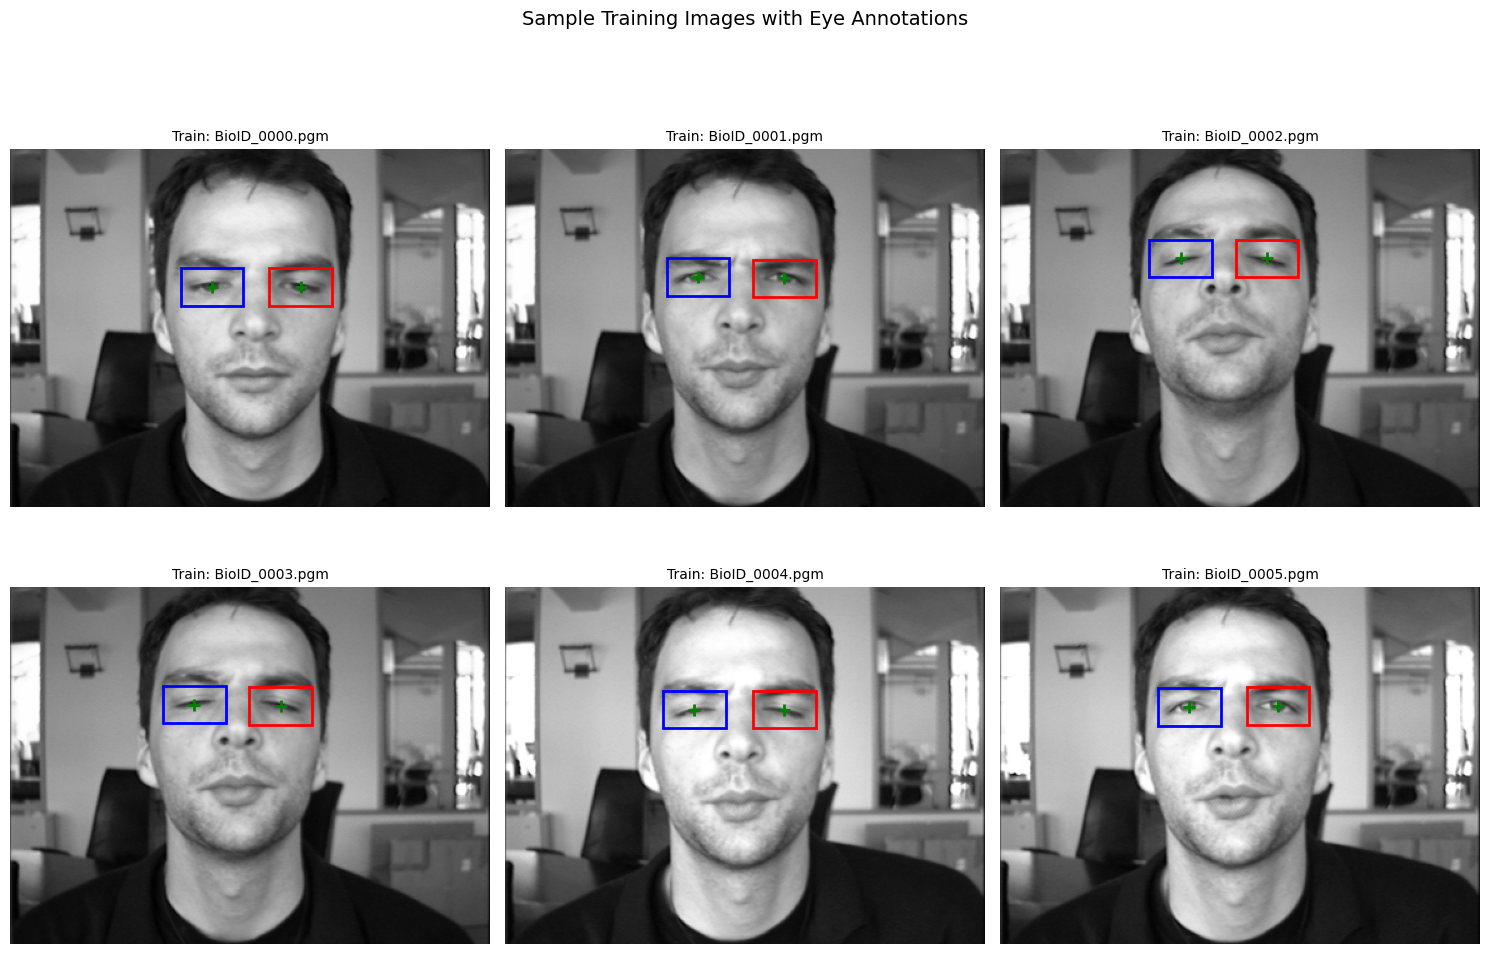


✓ Dataset visualization complete!


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = train_df['image_name'].unique()[:6]

for idx, img_name in enumerate(sample_images):
    img_annotations = train_df[train_df['image_name'] == img_name]
    img_path = img_annotations.iloc[0]['image_path']
    
    image = read_pgm(img_path)
    axes[idx].imshow(image, cmap='gray')
    
    for _, row in img_annotations.iterrows():
        x_min = row['bbox_x_min']
        y_min = row['bbox_y_min']
        width = row['bbox_x_max'] - x_min
        height = row['bbox_y_max'] - y_min
        
        color = 'red' if row['eye_type'] == 'left' else 'blue'
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        axes[idx].add_patch(rect)
        
        axes[idx].plot(row['center_x'], row['center_y'], 'g+', 
                      markersize=8, markeredgewidth=2)
    
    axes[idx].set_title(f"Train: {img_name}", fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Training Images with Eye Annotations', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Dataset visualization complete!")

In [ ]:
train_df.to_csv(os.path.join(output_dir, 'train_annotations.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'val_annotations.csv'), index=False)

print("Saved annotation CSVs:")
print(f"  - {output_dir}/train_annotations.csv")
print(f"  - {output_dir}/val_annotations.csv")

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Total Images: {len(unique_images)}")
print(f"Total Eye Annotations: {len(df)}")
print(f"\nTraining Set:")
print(f"  Images: {len(train_images)}")
print(f"  Annotations: {len(train_df)}")
print(f"\nValidation Set:")
print(f"  Images: {len(val_images)}")
print(f"  Annotations: {len(val_df)}")
print(f"\nBounding Box Size:")
print(f"  Width: {BOX_WIDTH} pixels")
print(f"  Height: {BOX_HEIGHT} pixels")
print(f"\nImage Dimensions: {df.iloc[0]['img_width']}x{df.iloc[0]['img_height']}")
print("="*60)

Saved annotation CSVs:
  - eye_detection_dataset/train_annotations.csv
  - eye_detection_dataset/val_annotations.csv

DATASET STATISTICS
Total Images: 1521
Total Eye Annotations: 3042

Training Set:
  Images: 1216
  Annotations: 2432

Validation Set:
  Images: 305
  Annotations: 610

Bounding Box Size:
  Width: 50 pixels
  Height: 30 pixels

Image Dimensions: 384x286


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

IMG_SIZE = 224  
GRID_SIZE = 7   
NUM_ANCHORS = 3 
NUM_CLASSES = 1 
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 50

ANCHORS = [
    (0.10, 0.08),  
    (0.15, 0.10),  
    (0.20, 0.12),  
]

print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nHyperparameters:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Anchors: {ANCHORS}")
print(f"  Grid Size: {GRID_SIZE}x{GRID_SIZE}")
print(f"  Anchor Boxes: {NUM_ANCHORS}")

Using device: cuda
  Epochs: 50
  Learning Rate: 0.001

Hyperparameters:
  Batch Size: 16
  Image Size: 224x224
  Anchors: [(0.1, 0.08), (0.15, 0.1), (0.2, 0.12)]
  Grid Size: 7x7
  Anchor Boxes: 3


In [ ]:
def calculate_iou_anchors(box_wh, anchor_wh):
    """Calculate IoU between box and anchor (both are w,h only)
    Assumes boxes are centered at the same point"""
    box_w, box_h = box_wh
    anchor_w, anchor_h = anchor_wh
    
    intersection = min(box_w, anchor_w) * min(box_h, anchor_h)
    box_area = box_w * box_h
    anchor_area = anchor_w * anchor_h
    union = box_area + anchor_area - intersection
    
    return intersection / union if union > 0 else 0

class EyeDetectionDataset(Dataset):
    """Custom dataset for eye detection with anchor boxes (YOLOv2 style)"""
    
    def __init__(self, dataframe, img_size=224, grid_size=7, anchors=None):
        self.df = dataframe
        self.img_size = img_size
        self.grid_size = grid_size
        self.anchors = anchors if anchors is not None else ANCHORS
        self.num_anchors = len(self.anchors)
        
        self.images = dataframe['image_name'].unique()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_annotations = self.df[self.df['image_name'] == img_name]
        img_path = img_annotations.iloc[0]['image_path']
        
        image = read_pgm(img_path)
        orig_h, orig_w = image.shape
        
        image = cv2.resize(image, (self.img_size, self.img_size))
        
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0)  
        image = torch.from_numpy(image).float()
        
        target = torch.zeros((self.grid_size, self.grid_size, self.num_anchors * (5 + NUM_CLASSES)))
        
        for _, row in img_annotations.iterrows(): 
            x_center = row['yolo_x_center']
            y_center = row['yolo_y_center']
            width = row['yolo_width']
            height = row['yolo_height']
            
            grid_x = int(x_center * self.grid_size)
            grid_y = int(y_center * self.grid_size)  
            
            grid_x = min(grid_x, self.grid_size - 1)
            grid_y = min(grid_y, self.grid_size - 1)  
            
            cell_x = (x_center * self.grid_size) - grid_x
            cell_y = (y_center * self.grid_size) - grid_y
              
            best_anchor_idx = 0
            best_iou = 0
            for anchor_idx, (anchor_w, anchor_h) in enumerate(self.anchors):
                iou = calculate_iou_anchors((width, height), (anchor_w, anchor_h))
                if iou > best_iou:
                    best_iou = iou
                    best_anchor_idx = anchor_idx
              
            anchor_w, anchor_h = self.anchors[best_anchor_idx] 
            
            tx = cell_x
            ty = cell_y 
            
            tw = np.log(width / anchor_w) if width > 0 and anchor_w > 0 else 0
            th = np.log(height / anchor_h) if height > 0 and anchor_h > 0 else 0
            
            base_idx = best_anchor_idx * (5 + NUM_CLASSES)
            target[grid_y, grid_x, base_idx + 0] = 1.0  
            target[grid_y, grid_x, base_idx + 1] = tx
            target[grid_y, grid_x, base_idx + 2] = ty
            target[grid_y, grid_x, base_idx + 3] = tw
            target[grid_y, grid_x, base_idx + 4] = th
            target[grid_y, grid_x, base_idx + 5] = 1.0  
        
        return image, target


print("Creating datasets with anchor boxes...")
train_dataset = EyeDetectionDataset(train_df, IMG_SIZE, GRID_SIZE, ANCHORS)
val_dataset = EyeDetectionDataset(val_df, IMG_SIZE, GRID_SIZE, ANCHORS)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Creating datasets with anchor boxes...
Training samples: 1216
Validation samples: 305
Training batches: 76
Validation batches: 20


In [ ]:
class YOLOv2EyeDetector(nn.Module):
    """YOLOv2-style architecture with anchor boxes for eye detection"""
    
    def __init__(self, grid_size=7, num_anchors=3, num_classes=1):
        super(YOLOv2EyeDetector, self).__init__()
        self.grid_size = grid_size
        self.num_anchors = num_anchors
        self.num_classes = num_classes
    
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )
        
        self.detection = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, num_anchors * (5 + num_classes), kernel_size=1, stride=1, padding=0),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.detection(x)
        
        batch_size = x.shape[0]
        x = x.permute(0, 2, 3, 1)  
        x = x.reshape(batch_size, self.grid_size, self.grid_size, -1)
        
        return x


model = YOLOv2EyeDetector(GRID_SIZE, NUM_ANCHORS, NUM_CLASSES).to(device)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture (YOLOv2 with Anchor Boxes):")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Output shape per cell: {NUM_ANCHORS} anchors × {5 + NUM_CLASSES} values = {NUM_ANCHORS * (5 + NUM_CLASSES)}")


Model Architecture (YOLOv2 with Anchor Boxes):
YOLOv2EyeDetector(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
class YOLOv2Loss(nn.Module):
    def __init__(self, grid_size=7, num_anchors=3, num_classes=1):
        super(YOLOv2Loss, self).__init__()
        self.grid_size = grid_size
        self.num_anchors = num_anchors
        self.num_classes = num_classes  
        
        self.lambda_coord = 5.0   
        self.lambda_noobj = 0.5   
        self.lambda_obj = 1.0     
        self.lambda_class = 1.0   
        
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        
    def forward(self, predictions, targets):
        """
        predictions: [batch, S, S, A*(5 + C)]
        targets: [batch, S, S, A*(5 + C)]
        where A = num_anchors, C = num_classes
        """
        batch_size = predictions.shape[0]
        
        
        loss_xy = 0      
        loss_wh = 0      
        loss_obj = 0     
        loss_noobj = 0   
        loss_class = 0   
        
        for b in range(batch_size):
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    for anchor_idx in range(self.num_anchors):
                        base_idx = anchor_idx * (5 + self.num_classes)
                        
                        pred_obj = predictions[b, i, j, base_idx + 0]
                        pred_tx = predictions[b, i, j, base_idx + 1]
                        pred_ty = predictions[b, i, j, base_idx + 2]
                        pred_tw = predictions[b, i, j, base_idx + 3]
                        pred_th = predictions[b, i, j, base_idx + 4]
                        pred_class = predictions[b, i, j, base_idx + 5:base_idx + 5 + self.num_classes]
                        
                        target_obj = targets[b, i, j, base_idx + 0]
                        target_tx = targets[b, i, j, base_idx + 1]
                        target_ty = targets[b, i, j, base_idx + 2]
                        target_tw = targets[b, i, j, base_idx + 3]
                        target_th = targets[b, i, j, base_idx + 4]
                        target_class = targets[b, i, j, base_idx + 5:base_idx + 5 + self.num_classes]
                        
                        if target_obj > 0:
                            loss_xy += self.mse(torch.sigmoid(pred_tx), target_tx)
                            loss_xy += self.mse(torch.sigmoid(pred_ty), target_ty)
                            
                            loss_wh += self.mse(pred_tw, target_tw)
                            loss_wh += self.mse(pred_th, target_th)
                            
                            loss_obj += self.bce(pred_obj.unsqueeze(0), target_obj.unsqueeze(0))
                            
                            if self.num_classes == 1:
                                loss_class += self.bce(pred_class, target_class)
                            else:
                                loss_class += self.mse(torch.sigmoid(pred_class), target_class)
                        else:
                            loss_noobj += self.bce(pred_obj.unsqueeze(0), 
                                                  torch.zeros(1).to(predictions.device))
        
        total_loss = (self.lambda_coord * (loss_xy + loss_wh) + 
                     self.lambda_obj * loss_obj + 
                     self.lambda_noobj * loss_noobj + 
                     self.lambda_class * loss_class)
        
        total_loss = total_loss / batch_size
        
        return total_loss


criterion = YOLOv2Loss(GRID_SIZE, NUM_ANCHORS, NUM_CLASSES)
print("Loss function created: YOLOv2Loss with Anchor Boxes")
print(f"  λ_coord = {criterion.lambda_coord}")
print(f"  λ_obj = {criterion.lambda_obj}")
print(f"  λ_noobj = {criterion.lambda_noobj}")
print(f"  λ_class = {criterion.lambda_class}")

Loss function created: YOLOv2Loss with Anchor Boxes
  λ_coord = 5.0
  λ_obj = 1.0
  λ_noobj = 0.5
  λ_class = 1.0


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',           
    factor=0.5,           
    patience=4,           
    min_lr=1e-6           
)

patience_early_stop = 3  
best_val_loss = float('inf')
epochs_no_improve = 0

print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"Early Stopping: patience={patience_early_stop} epochs")

history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []  
}

print("\n" + "="*60)
print("Ready to train!")
print("="*60)

Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
Early Stopping: patience=3 epochs

Ready to train!


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(dataloader):
        images = images.to(device)
        targets = targets.to(device)  
        
        optimizer.zero_grad()
        outputs = model(images)
           
        loss = criterion(outputs, targets)
           
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
         
        if (batch_idx + 1) % 20 == 0:
            print(f"  Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images) 
            
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

print("Training functions defined!")

Training functions defined!


In [ ]:

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    val_loss = validate(model, val_loader, criterion, device)

    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_eye_detector.pth')
        print(f"  ✓ Best model saved! (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")
    
    scheduler.step(val_loss)
    
    if epochs_no_improve >= patience_early_stop:
        print(f"\n⚠ Early stopping triggered! No improvement for {patience_early_stop} epochs.")
        print(f"Best validation loss: {best_val_loss:.4f}")
        break
    
    print()

print("="*60)
if epochs_no_improve >= patience_early_stop:
    print("Training stopped early!")
else:
    print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Total epochs trained: {epoch+1}")
print("="*60)

Starting training...

Epoch [1/50]
  Batch [20/76], Loss: 12.7233
  Batch [40/76], Loss: 9.6246
  Batch [60/76], Loss: 8.1724
  Train Loss: 29.5827, Val Loss: 7.5803, LR: 0.001000
  ✓ Best model saved! (Val Loss: 7.5803)

Epoch [2/50]
  Batch [20/76], Loss: 6.5244
  Batch [40/76], Loss: 5.6800
  Batch [60/76], Loss: 5.7940
  Train Loss: 6.2915, Val Loss: 5.3390, LR: 0.001000
  ✓ Best model saved! (Val Loss: 5.3390)

Epoch [3/50]
  Batch [20/76], Loss: 4.9943
  Batch [40/76], Loss: 4.4451
  Batch [60/76], Loss: 4.5636
  Train Loss: 4.4924, Val Loss: 4.0457, LR: 0.001000
  ✓ Best model saved! (Val Loss: 4.0457)

Epoch [4/50]
  Batch [20/76], Loss: 3.2033
  Batch [40/76], Loss: 3.3475
  Batch [60/76], Loss: 2.6049
  Train Loss: 3.3078, Val Loss: 3.2609, LR: 0.001000
  ✓ Best model saved! (Val Loss: 3.2609)

Epoch [5/50]
  Batch [20/76], Loss: 2.2749
  Batch [40/76], Loss: 2.9445
  Batch [60/76], Loss: 2.5203
  Train Loss: 2.5031, Val Loss: 2.4408, LR: 0.001000
  ✓ Best model saved! (Val L

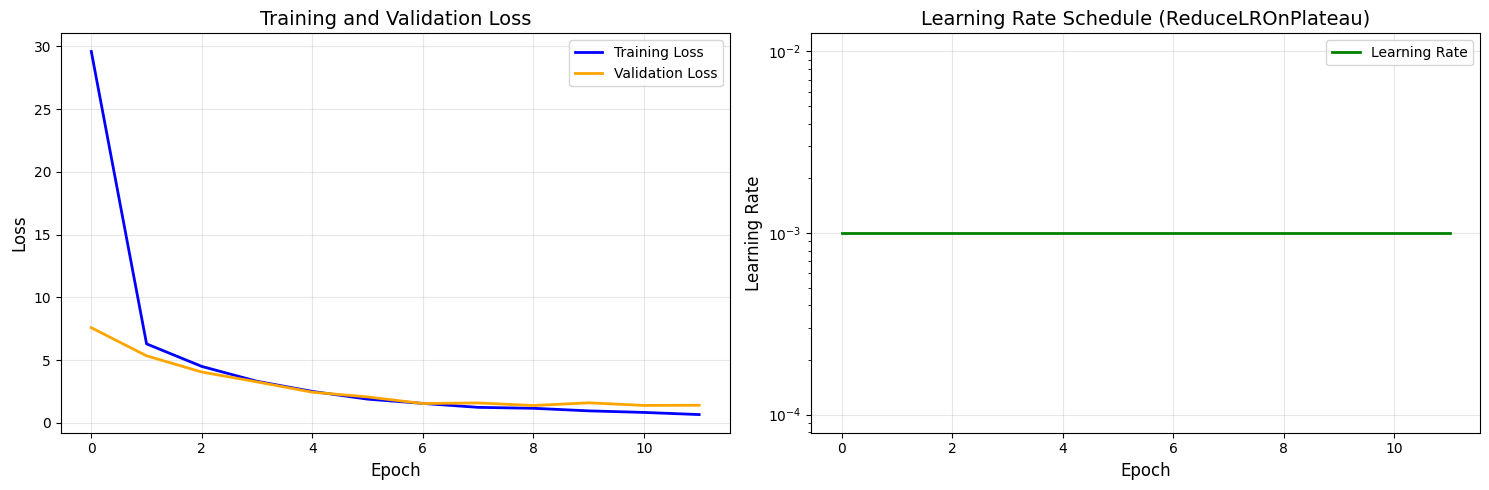

Training curve plotted! Trained for 12 epochs


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Training Loss', linewidth=2, color='blue')
ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(history['lr'], label='Learning Rate', linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule (ReduceLROnPlateau)', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')  

plt.tight_layout()
plt.show()

print(f"Training curve plotted! Trained for {len(history['train_loss'])} epochs")

In [ ]:

def predict_eyes(model, image_path, anchors=ANCHORS, threshold=0.3, top_k=None):
    """Predict eyes in an image using YOLOv2 with anchor boxes
    
    Args:
        model: Trained YOLOv2 model
        image_path: Path to image
        anchors: List of anchor box dimensions (w, h)
        threshold: Objectness threshold
        top_k: If specified, return only top k detections by confidence
    """
    model.eval()
    
    
    image = read_pgm(image_path)
    orig_h, orig_w = image.shape
    
    
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image_tensor = torch.from_numpy(image_resized).float().unsqueeze(0).unsqueeze(0) / 255.0
    image_tensor = image_tensor.to(device)
    
    
    with torch.no_grad():
        output = model(image_tensor)
    
    
    output = output.cpu().squeeze(0)  
    detections = []
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for anchor_idx in range(len(anchors)):
                base_idx = anchor_idx * (5 + NUM_CLASSES)
                
                
                objectness = torch.sigmoid(output[i, j, base_idx + 0])
                
                if objectness > threshold:
                    
                    tx = torch.sigmoid(output[i, j, base_idx + 1])
                    ty = torch.sigmoid(output[i, j, base_idx + 2])
                    tw = output[i, j, base_idx + 3]
                    th = output[i, j, base_idx + 4]
                    
                    
                    anchor_w, anchor_h = anchors[anchor_idx]
                    
                    
                    bx = (j + tx.item()) / GRID_SIZE
                    by = (i + ty.item()) / GRID_SIZE
                    bw = anchor_w * np.exp(tw.item())
                    bh = anchor_h * np.exp(th.item())
                    
                    
                    x_center = bx * orig_w
                    y_center = by * orig_h
                    width = bw * orig_w
                    height = bh * orig_h
                    
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    
                    
                    x1 = max(0, min(x1, orig_w))
                    y1 = max(0, min(y1, orig_h))
                    x2 = max(0, min(x2, orig_w))
                    y2 = max(0, min(y2, orig_h))
                    
                    detections.append({
                        'confidence': objectness.item(),
                        'bbox': (x1, y1, x2, y2),
                        'anchor_idx': anchor_idx
                    })
    
    
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    
    
    if top_k is not None:
        detections = detections[:top_k]
    
    return image, detections

print("Inference function defined (YOLOv2 with Anchor Boxes)!")

Inference function defined (YOLOv2 with Anchor Boxes)!


## YOLOv2 with Anchor Boxes - Key Changes

**What are Anchor Boxes?**
Anchor boxes are predefined bounding box shapes that the model learns to adjust. Instead of predicting box dimensions directly, the model predicts offsets from these anchors.

**Benefits:**
1. **Better Localization**: Anchors match typical eye shapes (wider than tall)
2. **Faster Convergence**: Model starts with reasonable box shapes
3. **Multiple Detections**: Each grid cell can detect multiple objects via different anchors

**Our Anchor Boxes:**
- Small: (0.10, 0.08) - for distant/small eyes  
- Medium: (0.15, 0.10) - typical eye size
- Large: (0.20, 0.12) - for close-up eyes

**Encoding:**
- `tx, ty`: Offsets within grid cell (0-1 range, use sigmoid)
- `tw, th`: Log-space offsets from anchor dimensions
- Decoding: `bw = anchor_w × exp(tw)`, `bh = anchor_h × exp(th)`

This approach directly addresses the huge bounding box issue by constraining predictions to reasonable anchor-based adjustments!

In [ ]:
print("=== MODEL OUTPUT DIAGNOSTIC ===")
model.eval()

sample_img_name = val_df['image_name'].unique()[0]
sample_annotations = val_df[val_df['image_name'] == sample_img_name]
sample_img_path = sample_annotations.iloc[0]['image_path']

print(f"\nTest image: {sample_img_name}")
print(f"Ground truth boxes:")
for _, row in sample_annotations.iterrows():
    print(f"  {row['eye_type']}: width={row['yolo_width']:.4f}, height={row['yolo_height']:.4f} (normalized)")
    print(f"    In pixels: {row['bbox_x_max']-row['bbox_x_min']}x{row['bbox_y_max']-row['bbox_y_min']}")


image = read_pgm(sample_img_path)
orig_h, orig_w = image.shape
image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image_tensor = torch.from_numpy(image_resized).float().unsqueeze(0).unsqueeze(0) / 255.0
image_tensor = image_tensor.to(device)

with torch.no_grad():
    output = model(image_tensor)

output = output.cpu().squeeze(0)

print(f"\nModel predictions (objectness > 0.1):")
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        for anchor_idx in range(NUM_ANCHORS):
            base_idx = anchor_idx * (5 + NUM_CLASSES)    
            
            obj = torch.sigmoid(output[i, j, base_idx + 0])
            
            if obj > 0.1:
                tx_raw = output[i, j, base_idx + 1].item()
                ty_raw = output[i, j, base_idx + 2].item()
                tw_raw = output[i, j, base_idx + 3].item()
                th_raw = output[i, j, base_idx + 4].item()
                
                tx_sigmoid = torch.sigmoid(output[i, j, base_idx + 1]).item()
                ty_sigmoid = torch.sigmoid(output[i, j, base_idx + 2]).item()
                
                
                anchor_w, anchor_h = ANCHORS[anchor_idx]
                
                bw = anchor_w * np.exp(tw_raw)
                bh = anchor_h * np.exp(th_raw)
                
                print(f"  Grid[{i},{j}] Anchor{anchor_idx}: obj={obj:.3f}")
                print(f"    Anchor: {anchor_w:.3f}x{anchor_h:.3f}")
                print(f"    Raw: tx={tx_raw:.3f}, ty={ty_raw:.3f}, tw={tw_raw:.3f}, th={th_raw:.3f}")
                print(f"    Decoded: tx={tx_sigmoid:.3f}, ty={ty_sigmoid:.3f}")
                print(f"    Box size (normalized): {bw:.3f}x{bh:.3f}")
                print(f"    In pixels: {int(bw*orig_w)}x{int(bh*orig_h)}")

print("\n" + "="*50)

=== MODEL OUTPUT DIAGNOSTIC ===

Test image: BioID_0015.pgm
Ground truth boxes:
  left: width=0.1302, height=0.1049 (normalized)
    In pixels: 50x30
  right: width=0.1302, height=0.1049 (normalized)
    In pixels: 50x30

Model predictions (objectness > 0.1):
  Grid[2,4] Anchor1: obj=0.744
    Anchor: 0.150x0.100
    Raw: tx=-1.566, ty=2.001, tw=-0.183, th=0.051
    Decoded: tx=0.173, ty=0.881
    Box size (normalized): 0.125x0.105
    In pixels: 47x30
  Grid[3,2] Anchor1: obj=0.999
    Anchor: 0.150x0.100
    Raw: tx=0.741, ty=-1.628, tw=-0.154, th=0.046
    Decoded: tx=0.677, ty=0.164
    Box size (normalized): 0.129x0.105
    In pixels: 49x29



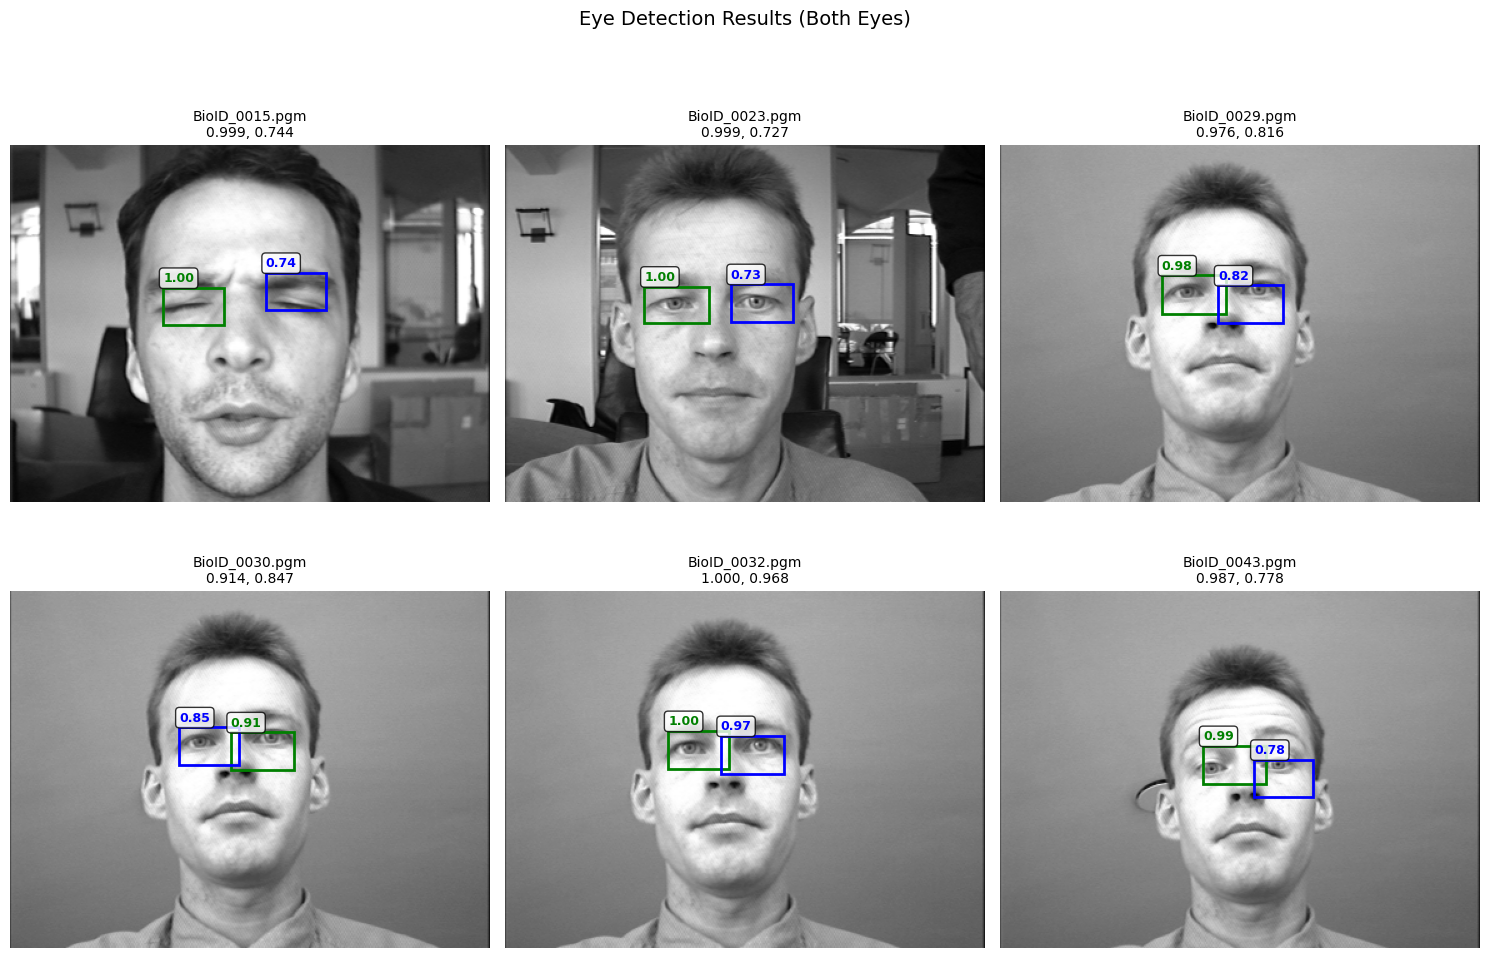

✓ Tested on 6 validation images


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

test_images = val_df['image_name'].unique()[:6]

for idx, img_name in enumerate(test_images):
    img_path = val_df[val_df['image_name'] == img_name].iloc[0]['image_path']
    
    image, detections = predict_eyes(model, img_path, threshold=0.1, top_k=2)
    
    axes[idx].imshow(image, cmap='gray')
    
    colors = ['green', 'blue']  
    for det_idx, det in enumerate(detections):
        x1, y1, x2, y2 = det['bbox']
        conf = det['confidence']
        color = colors[det_idx] if det_idx < len(colors) else 'yellow'
        
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        axes[idx].add_patch(rect)
        axes[idx].text(x1, y1-5, f'{conf:.2f}', color=color, fontsize=9,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                      fontweight='bold')
    
    
    conf_text = ", ".join([f"{d['confidence']:.3f}" for d in detections]) if detections else "No detections"
    axes[idx].set_title(f"{img_name}\n{conf_text}", fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Eye Detection Results (Both Eyes)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"✓ Tested on {len(test_images)} validation images")


## Average Precision (AP) Metric

Calculate Average Precision to evaluate detection quality. AP measures the area under the precision-recall curve.

In [ ]:
def calculate_iou(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i < x1_i or y2_i < y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    
    
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    iou = intersection / union if union > 0 else 0.0
    return iou

def calculate_ap(predictions, ground_truths, iou_threshold=0.5):
    if len(predictions) == 0:
        return 0.0
    
    if len(ground_truths) == 0:
        return 0.0
    
    predictions = sorted(predictions, key=lambda x: x['confidence'], reverse=True)
    
    matched_gt = [False] * len(ground_truths)
    
    tp = []  
    fp = []  
    
    for pred in predictions:
        pred_box = pred['bbox']
        
        best_iou = 0.0
        best_gt_idx = -1
        
        for gt_idx, gt_box in enumerate(ground_truths):
            if matched_gt[gt_idx]:
                continue
            
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
    
        if best_iou >= iou_threshold and best_gt_idx != -1:
            tp.append(1)
            fp.append(0)
            matched_gt[best_gt_idx] = True
        else:
            tp.append(0)
            fp.append(1)
    
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    
    recalls = tp_cumsum / len(ground_truths)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    
    recalls = np.concatenate([[0], recalls, [1]])
    precisions = np.concatenate([[0], precisions, [0]])
    
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11.0
    
    return ap

print("IoU and AP calculation functions defined!")

IoU and AP calculation functions defined!


Evaluating model on validation set...

Validation Results:
  Number of images: 305
  Total predictions: 800
  Total ground truths: 610
  Mean Average Precision (mAP@0.5): 0.7327
  Percentage: 73.27%


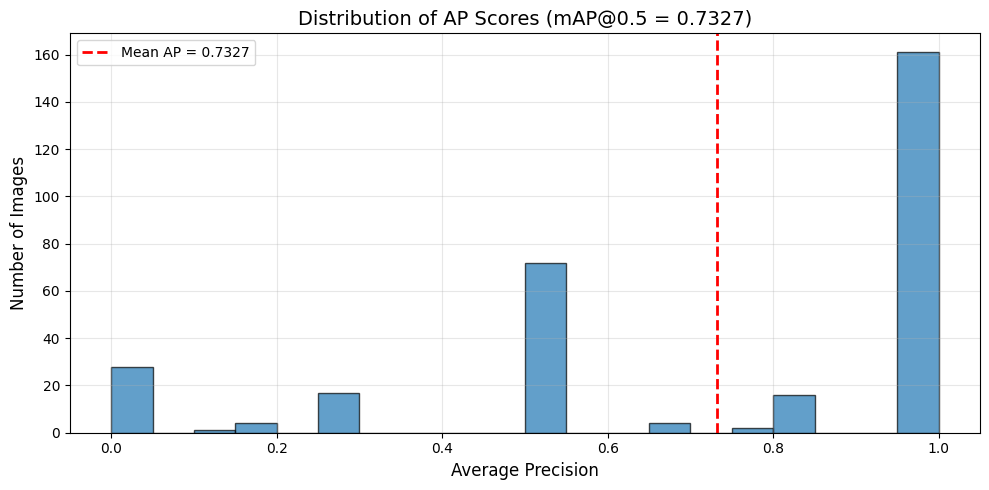

In [ ]:
print("Evaluating model on validation set...")
print("="*60)

all_predictions = []
all_ground_truths = []
aps_per_image = []

for img_name in val_df['image_name'].unique():
    img_annotations = val_df[val_df['image_name'] == img_name]
    img_path = img_annotations.iloc[0]['image_path']
    
    _, detections = predict_eyes(model, img_path, threshold=0.1, top_k=None)
    
    gt_boxes = []
    for _, row in img_annotations.iterrows():
        gt_boxes.append((
            int(row['bbox_x_min']),
            int(row['bbox_y_min']),
            int(row['bbox_x_max']),
            int(row['bbox_y_max'])
        ))
    
    pred_list = [{'confidence': d['confidence'], 'bbox': d['bbox']} for d in detections]
    ap = calculate_ap(pred_list, gt_boxes, iou_threshold=0.5)
    aps_per_image.append(ap)
    
    all_predictions.extend(pred_list)
    all_ground_truths.extend(gt_boxes)


mAP = np.mean(aps_per_image)

print(f"\nValidation Results:")
print(f"  Number of images: {len(aps_per_image)}")
print(f"  Total predictions: {len(all_predictions)}")
print(f"  Total ground truths: {len(all_ground_truths)}")
print(f"  Mean Average Precision (mAP@0.5): {mAP:.4f}")
print(f"  Percentage: {mAP*100:.2f}%")
print("="*60)

plt.figure(figsize=(10, 5))
plt.hist(aps_per_image, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Average Precision', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title(f'Distribution of AP Scores (mAP@0.5 = {mAP:.4f})', fontsize=14)
plt.axvline(mAP, color='red', linestyle='--', linewidth=2, label=f'Mean AP = {mAP:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

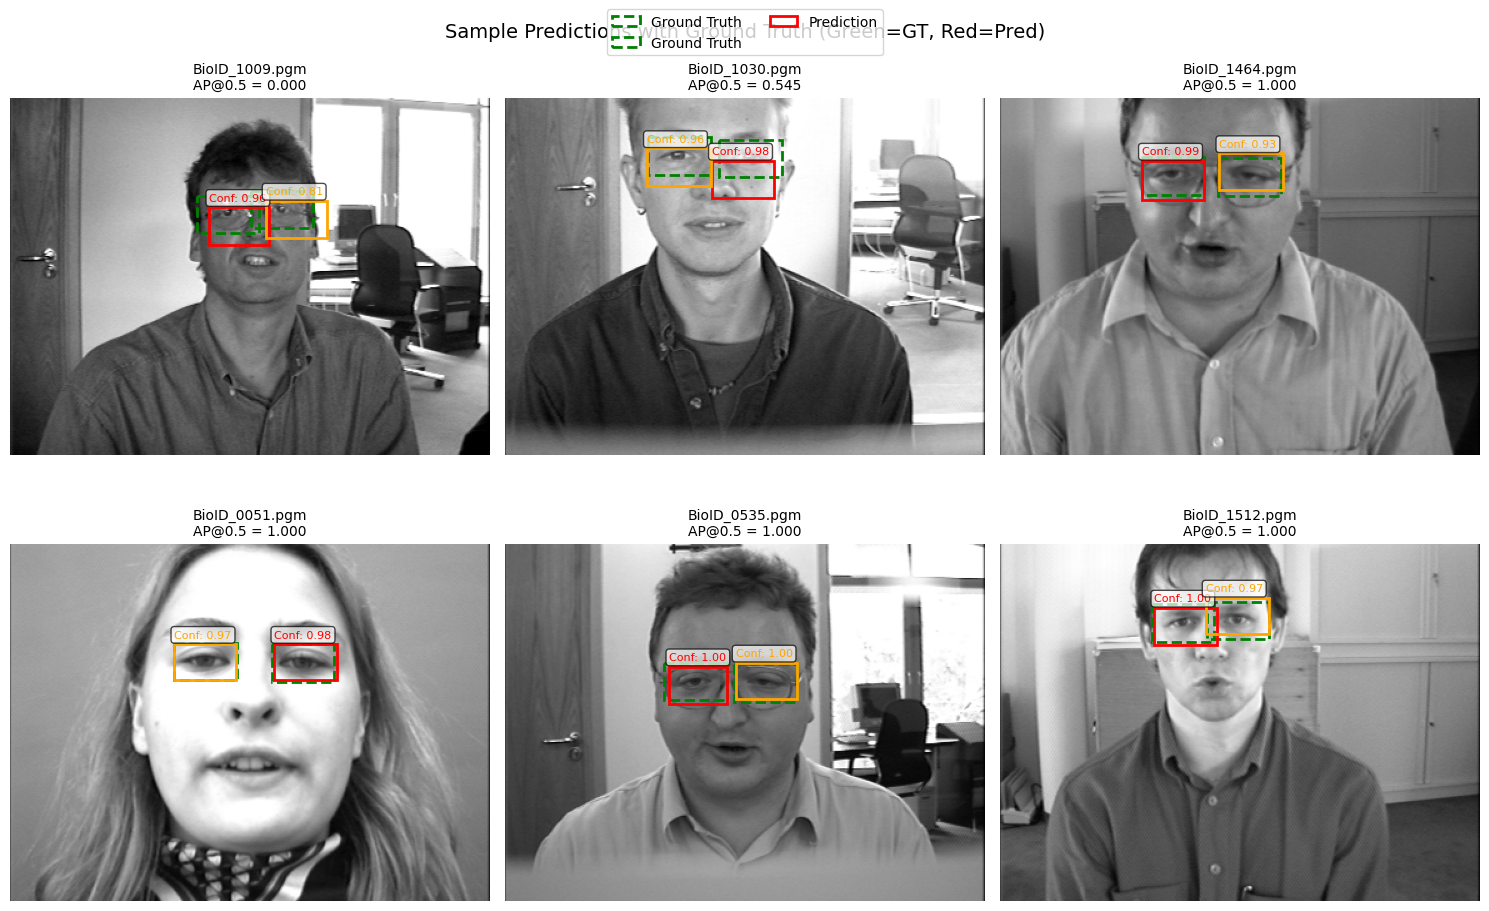


✓ Visualized samples with AP ranging from 0.000 to 1.000


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sorted_indices = np.argsort(aps_per_image)
sample_indices = [
    sorted_indices[0],  
    sorted_indices[len(sorted_indices)//4],
    sorted_indices[len(sorted_indices)//2],  
    sorted_indices[3*len(sorted_indices)//4],
    sorted_indices[-2],  
    sorted_indices[-1]   
]

unique_val_images = val_df['image_name'].unique()

for plot_idx, img_idx in enumerate(sample_indices):
    img_name = unique_val_images[img_idx]
    img_annotations = val_df[val_df['image_name'] == img_name]
    img_path = img_annotations.iloc[0]['image_path']
    
    image, detections = predict_eyes(model, img_path, threshold=0.1, top_k=2)
    ap_score = aps_per_image[img_idx]
    
    axes[plot_idx].imshow(image, cmap='gray')
    
    for _, row in img_annotations.iterrows():
        rect = patches.Rectangle(
            (row['bbox_x_min'], row['bbox_y_min']),
            row['bbox_x_max'] - row['bbox_x_min'],
            row['bbox_y_max'] - row['bbox_y_min'],
            linewidth=2, edgecolor='green', facecolor='none', linestyle='--',
            label='Ground Truth'
        )
        axes[plot_idx].add_patch(rect)
    
    pred_colors = ['red', 'orange']
    for det_idx, det in enumerate(detections):
        x1, y1, x2, y2 = det['bbox']
        color = pred_colors[det_idx] if det_idx < len(pred_colors) else 'yellow'
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=color, facecolor='none',
            label='Prediction' if det_idx == 0 else ''
        )
        axes[plot_idx].add_patch(rect)
        axes[plot_idx].text(x1, y1-5, f"Conf: {det['confidence']:.2f}", 
                           color=color, fontsize=8,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    axes[plot_idx].set_title(f"{img_name}\nAP@0.5 = {ap_score:.3f}", fontsize=10)
    axes[plot_idx].axis('off')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=10)

plt.suptitle('Sample Predictions with Ground Truth (Green=GT, Red=Pred)', fontsize=14, y=0.96)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized samples with AP ranging from {min(aps_per_image):.3f} to {max(aps_per_image):.3f}")